In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [24]:
df = pd.read_csv('/content/drive/MyDrive/PLN_Timeseries/442100110323_standard.csv')
df['READ_DATE'] = pd.to_datetime(df['READ_DATE'])
df.set_index('READ_DATE', inplace=True)
df


,KWH_EXP
READ_DATE,
2019-01-01 00:00:00,2.334143
2019-01-01 00:15:00,2.344050
2019-01-01 00:30:00,2.500311
2019-01-01 00:45:00,2.432096
2019-01-01 01:00:00,2.388465
...,...
2024-05-31 21:45:00,68.226236
2024-05-31 22:00:00,69.132420
2024-05-31 23:15:00,68.774401


In [25]:
scaler = StandardScaler()

In [26]:
# split data train dan test. 3 tahun pertama untuk train, 2 tahun terakhir untuk test
train = df.loc['2019-01-01':'2022-12-31']
test = df.loc['2023-01-01':]

In [27]:
# scaling data train
train_scaled = scaler.fit_transform(train)
train_scaled = pd.DataFrame(train_scaled, columns=train.columns, index=train.index)
train_scaled



,KWH_EXP
READ_DATE,
2019-01-01 00:00:00,-0.913157
2019-01-01 00:15:00,-0.911948
2019-01-01 00:30:00,-0.892871
2019-01-01 00:45:00,-0.901199
2019-01-01 01:00:00,-0.906525
...,...
2022-12-31 22:45:00,-0.848218
2022-12-31 23:00:00,-0.840862
2022-12-31 23:15:00,-0.842761


In [28]:
# scaling data test
test_scaled = scaler.transform(test)
test_scaled = pd.DataFrame(test_scaled, columns=test.columns, index=test.index)
test_scaled

,KWH_EXP
READ_DATE,
2023-01-01 00:00:00,-0.836886
2023-01-01 00:15:00,-0.830567
2023-01-01 00:30:00,-0.833519
2023-01-01 00:45:00,-0.856909
2023-01-01 01:00:00,-0.828039
...,...
2024-05-31 21:45:00,7.131126
2024-05-31 22:00:00,7.241755
2024-05-31 23:15:00,7.198047


In [29]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [30]:
# jika datanya diambil setiap 15 menit, maka time_steps = 96 berarti 24 jam

time_steps = 96
# reshape ke bentuk 3D array
X_train, y_train = create_dataset(train_scaled, train_scaled['KWH_EXP'], time_steps)
X_test, y_test = create_dataset(test_scaled, test_scaled['KWH_EXP'], time_steps)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(122823, 96, 1) (122823,)
(43087, 96, 1) (43087,)


In [31]:
model = Sequential()
model.add(LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [32]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 96, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 116,033 (453.25 KB)

 Trainable params: 116,033 (453.25 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
#  callback
# early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')
# learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

# training
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    shuffle=False,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/100
3455/3455 ━━━━━━━━━━━━━━━━━━━━ 36s 10ms/step - loss: 0.0381 - val_loss: 0.0104 - learning_rate: 0.0010
Epoch 2/100
3455/3455 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - loss: 0.0183 - val_loss: 0.0102 - learning_rate: 0.0010
Epoch 3/100
3455/3455 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - loss: 0.0180 - val_loss: 0.0097 - learning_rate: 0.0010
Epoch 4/100
3455/3455 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - loss: 0.0177 - val_loss: 0.0094 - learning_rate: 0.0010
Epoch 5/100
3455/3455 ━━━━━━━━━━━━━━━━━━━━ 33s 10ms/step - loss: 0.0176 - val_loss: 0.0092 - learning_rate: 0.0010
Epoch 6/100
3455/3455 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - loss: 0.0175 - val_loss: 0.0088 - learning_rate: 9.0484e-04
Epoch 7/100
3455/3455 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - loss: 0.0173 - val_loss: 0.0085 - learning_rate: 8.1873e-04
Epoch 8/100
3455/3455 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - loss: 0.0171 - val_loss: 0.0082 - learning_rate: 7.4082e-04
Epoch 9/100
3455/3455 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - loss: 0.0

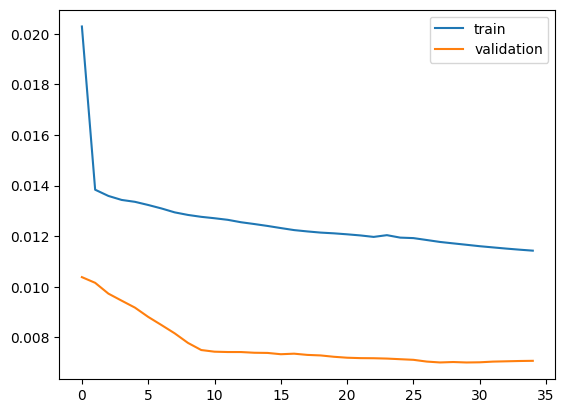

In [34]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [35]:
# predict

y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))  # Balikkan prediksi ke skala asli
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))  # Balikkan y_test juga

1347/1347 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step


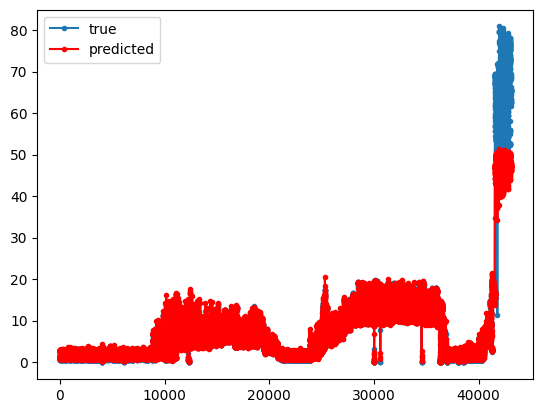

In [36]:
plt.plot(y_test, marker='.', label='true')
plt.plot(y_pred, 'r', marker='.', label='predicted')
plt.legend()
plt.show()

In [37]:
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MSE: 10.477396267926753
MAE: 0.8132378922955699
R2: 0.9228333857400364
MAPE: 12976463008630.562
